In [ ]:
!pip install transformers datasets torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_6

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 training completed. Avg Loss: 0.5556879764665728
Epoch 1 validation completed. Avg Loss: 0.4409114420413971
Epoch 2 training completed. Avg Loss: 0.3208290546970523
Epoch 2 validation completed. Avg Loss: 0.35795140295074535
Epoch 3 training completed. Avg Loss: 0.16014024291349493
Epoch 3 validation completed. Avg Loss: 0.37770896376325536
Epoch 4 training completed. Avg Loss: 0.11812506641220788
Epoch 4 validation completed. Avg Loss: 0.37770896376325536
Epoch 5 training completed. Avg Loss: 0.12037926747099213
Epoch 5 validation completed. Avg Loss: 0.37770896376325536
Epoch 6 training completed. Avg Loss: 0.11724234126184298
Epoch 6 validation completed. Avg Loss: 0.37770896376325536
Epoch 7 training completed. Avg Loss: 0.11940343028501324
Epoch 7 validation completed. Avg Loss: 0.37770896376325536
Epoch 8 training completed. Avg Loss: 0.12048089784448561
Epoch 8 validation completed. Avg Loss: 0.37770896376325536
Epoch 9 training completed. Avg Loss: 0.12320867621380349
E

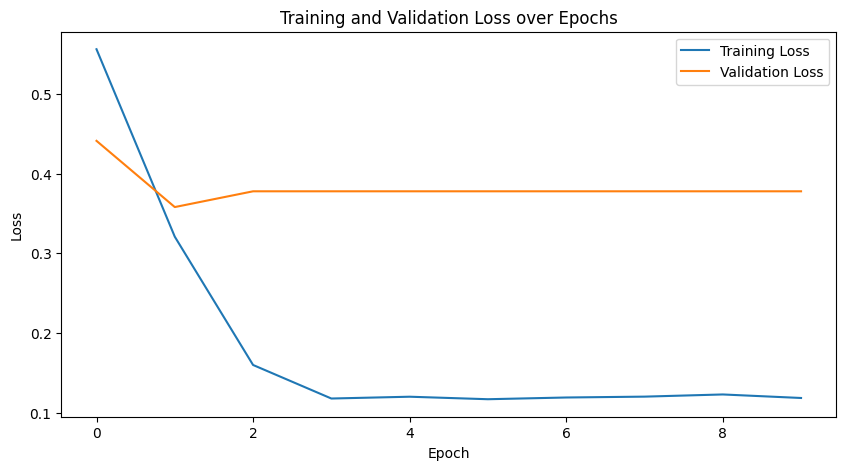

Final Validation accuracy: 0.8725490196078431


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
import matplotlib.pyplot as plt

# Step 2: Load the pre-trained BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming binary classification

# Step 3: Prepare the dataset
def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', max_length=128)

# Load the dataset
dataset = load_dataset('glue', 'mrpc')

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Format the dataset
tokenized_datasets = tokenized_datasets.remove_columns(['sentence1', 'sentence2', 'idx'])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch')

# Create DataLoader
train_loader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True)
validation_loader = DataLoader(tokenized_datasets['validation'], batch_size=16)

# Step 4: Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3  # Number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Step 5: Training loop with loss tracking
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

for epoch in range(10):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} training completed. Avg Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} validation completed. Avg Loss: {avg_val_loss}")

# Step 6: Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluation (optional, if you want to check final accuracy)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in validation_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == batch['labels']).sum().item()
        total += batch['labels'].size(0)

accuracy = correct / total
print(f"Final Validation accuracy: {accuracy}")